# Depression and Anxiety classification visualization

Based on the study by [Cavanagh et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6515849/)

Import packages

In [99]:
import io
import mne
import copy
import glob
import array
import matplotlib
import numpy as np
import pandas as pd
import sklearn.metrics
import seaborn as sns
import scipy.io as sio
import plotly.express as px
import matplotlib.pyplot as plt
import copy

from itertools import chain
from sklearn.svm import SVC
from scipy.io import loadmat
from sklearn import set_config

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import permutation_test_score

from matplotlib.colors import ListedColormap

from mne.time_frequency import tfr_morlet

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer

from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA, FastICA

from scipy import stats

# parameters for plotting
plt.rcParams["figure.figsize"] = (10,7)

import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

from mne.time_frequency import (
    tfr_multitaper,
    tfr_stockwell,
    tfr_morlet,
    tfr_array_morlet,
    AverageTFR,
)

## Load EEG data

In [2]:
data_df = pd.read_pickle("data/sonata_data/sonata_data_GNG_autoreject_freq_short.pkl")

In [3]:
dep = data_df[(data_df['BDI'] > 13) & (data_df['STAI'] > 41)]
len(dep)

75

In [4]:
ctrl_dep = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 41)]
len(ctrl_dep)

72

In [5]:
anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] > 42)]
len(anx)

65

In [6]:
ctrl_anx = data_df[(data_df['BDI'] <= 13) & (data_df['STAI'] < 41)]
len(ctrl_anx)

66

## Visualize positive feedback, negative feedback and difference waves

Concatenate epochs from all participants

In [ ]:
epochs = mne.concatenate_epochs(data_df['epochs'].to_list())

Create grand averages per condition

In [8]:
evokeds = [epochs[name].average().copy().crop(tmin=-0.1, tmax=0.6) for name in ('f_good', 'f_bad')]
evokeds_diff_data = evokeds[0].get_data() - evokeds[1].get_data()
evoked_diff = mne.EvokedArray(evokeds_diff_data, info = evokeds[0].info, tmin = evokeds[0].tmin,)

#### Plot condition wavelines

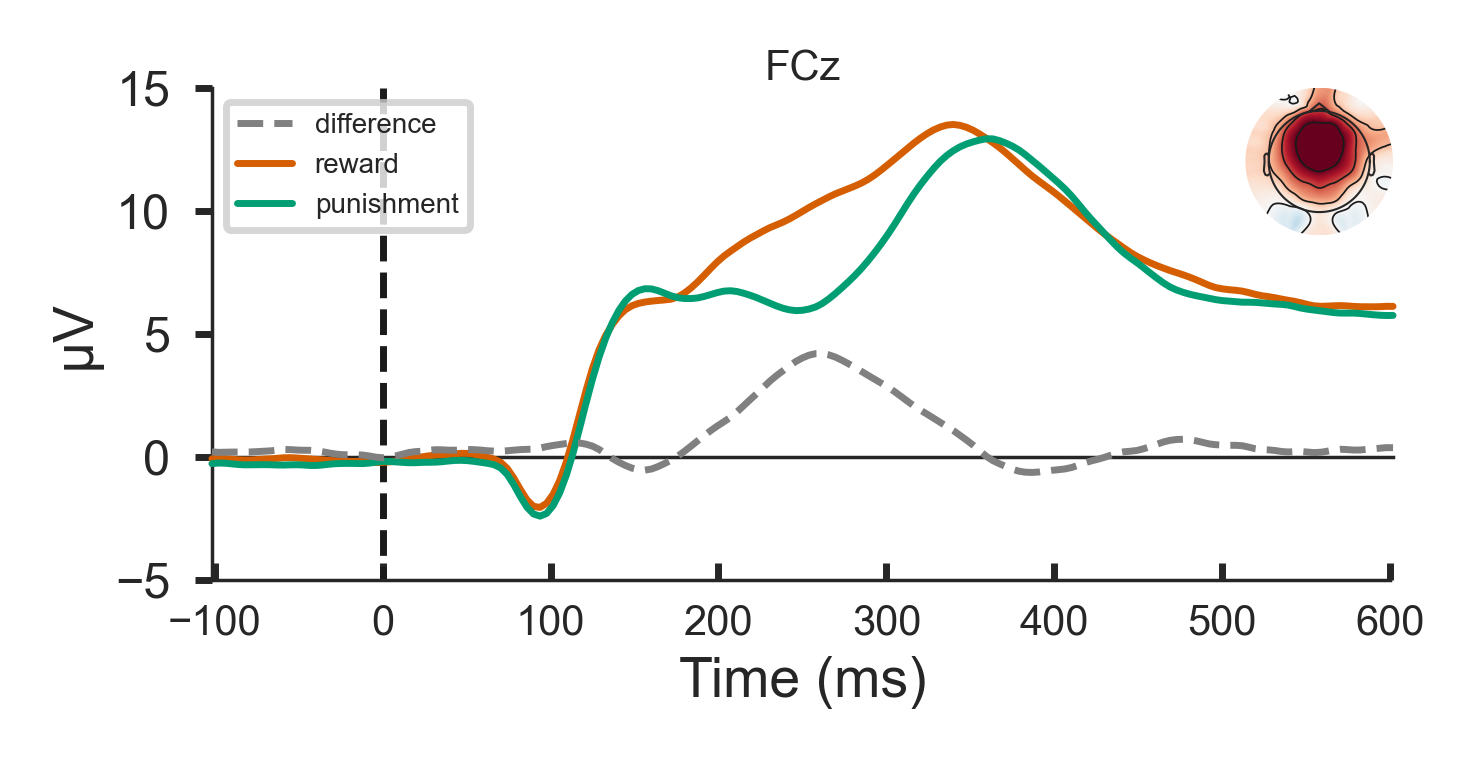

In [51]:
# plot parameters
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)
plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2

# plot colormap
colors = [sns.color_palette("colorblind")[3], sns.color_palette("colorblind")[2], 'gray']
c_map = ListedColormap(sns.color_palette(colors).as_hex())
c_map = matplotlib.colors.LinearSegmentedColormap.from_list("", [sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[3]])
sns.set_palette(colors)

# create canvas
fig = plt.figure(figsize=(6*cm, 2.5*cm))
ax = fig.add_axes([0,0,1,1], zorder=-1)

# add axes from topo maps
topo_axis = fig.add_axes([0.7,0.7,0.3,0.3], anchor='NE', zorder=2)
topo_axis_cbar = fig.add_axes([0.1,0.12,10,200], anchor='NE', zorder=10)

# plot topomap
topo_fig = mne.viz.plot_evoked_topomap(
    evoked = evoked_diff,
    times = [0.25],
    vlim = (3,-3),
    show=False,
    axes=[topo_axis,topo_axis_cbar],
    sensors=False,
    outlines='head',
    # cmap=c_map,
    sphere='auto',
    extrapolate='head'
    
)

topo_axis_cbar.remove()
topo_axis.set_title('', size=7, pad=4) # Title
plt.setp(topo_axis.lines , linewidth=0.3)

# plot condition wavelines
fig_list = mne.viz.plot_compare_evokeds(
    {'reward':evokeds[0], 'punishment':evokeds[1], 'difference': evoked_diff},
    picks=['FCz'], 
    ci=0.95, 
    time_unit='ms',
    ylim=dict(eeg=[-5, 15]),
    show_sensors=False,
    styles={"difference": {"linestyle": '--'}},
    axes=ax,
    legend = 'upper left',
    show=False,
)

fig_list[0].axes[0].tick_params(axis='x', direction='in', length=2.5, width=1)
fig_list[0].axes[0].tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()

fig.savefig(f'data/figure_1/conditions_wave_plot_head', bbox_inches='tight', pad_inches=0.01)

## Time-frequency analysis

### Global time-frequency decomposition

Create grand average across all conditions to find delta and theta frequency ranges

In [10]:
evoked_all_conditions = epochs.average()

Create time-frequency representation of the grand average

In [ ]:
# Factor to down-sample the temporal dimension of the TFR computed by tfr_morlet.
decim = 1

# frequencies of interest in log distribution
freqs = np.linspace(0.2, 15, num=60)  
cycles = freqs / 0.8

# morelet parameters (number of cycles)
n_cycles = cycles

epochs_power = list()
tfr = list()

# perform morlet TF decomposition
tfr = tfr_morlet(
    evoked_all_conditions, 
    freqs, 
    n_cycles=n_cycles,
    decim=decim, 
    average=True, 
    return_itc=False, 
    verbose=0, 
    n_jobs=10
)

Plot time-frequency decomposed signal

Applying baseline correction (mode: mean)
['−0.2', '−0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7']
['0.0', '2.5', '5.0', '7.5', '10.0', '12.5']


/tmp/ipykernel_4613/165935736.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
/tmp/ipykernel_4613/165935736.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels_y)


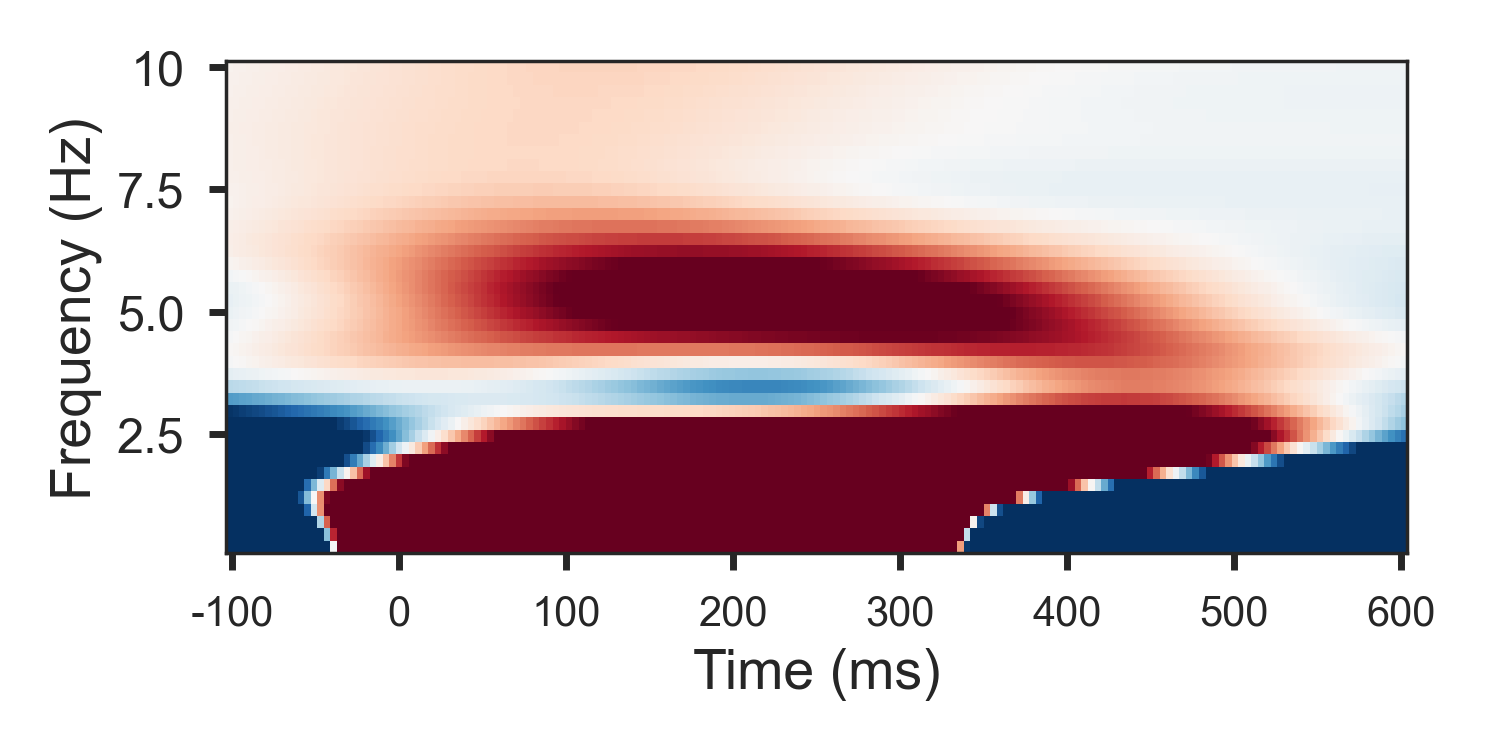

In [17]:
# plot parameters
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 8
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.titlesize'] = 6
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)
plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2

# create canvas
fig = plt.figure(figsize=(6*cm, 2.5*cm))
ax = fig.add_axes([0,0,1,1], zorder=-1)

# plot TF
tfr.plot(
    ['FCz'],
    baseline=(-0.9, 0), 
    mode="mean", 
    show=False, 
    # colorbar=True,
    vmin=-1e-10,
    vmax=1e-10,
    tmin=-0.1, 
    tmax=0.6,
    axes=ax,
    colorbar=False,
    fmin=0,
    fmax=10,
)

# refine labels to match log distribution
labels = [item.get_text() for item in ax.get_xticklabels()]
print(labels)
labels[1] = '-100'
labels[2] = '0'
labels[3] = '100'
labels[4] = '200'
labels[5] = '300'
labels[6] = '400'
labels[7] = '500'
labels[8] = '600'
ax.set_xticklabels(labels)

labels_y = [item.get_text() for item in ax.get_yticklabels()]
print(labels_y)
labels_y[4] = 10
ax.set_yticklabels(labels_y)

plt.xlabel('Time (ms)')

ax.tick_params(axis='x', direction='out', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()
fig.savefig(f'data/figure_1/tfr_600', bbox_inches='tight', pad_inches=0.01)

### Theta and delta frequencies plots per groups

#### Depression: delta

In [ ]:
depression_epochs = mne.concatenate_epochs(dep['delta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['delta'].to_list())

In [65]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]

evokeds = {
    'reward DEP': evokeds_dep[0],
    'reward CTR': evokeds_dep_ctr[0],
    'punishment DEP' : evokeds_dep[1],
    'punishment CTR' : evokeds_dep_ctr[1],
}

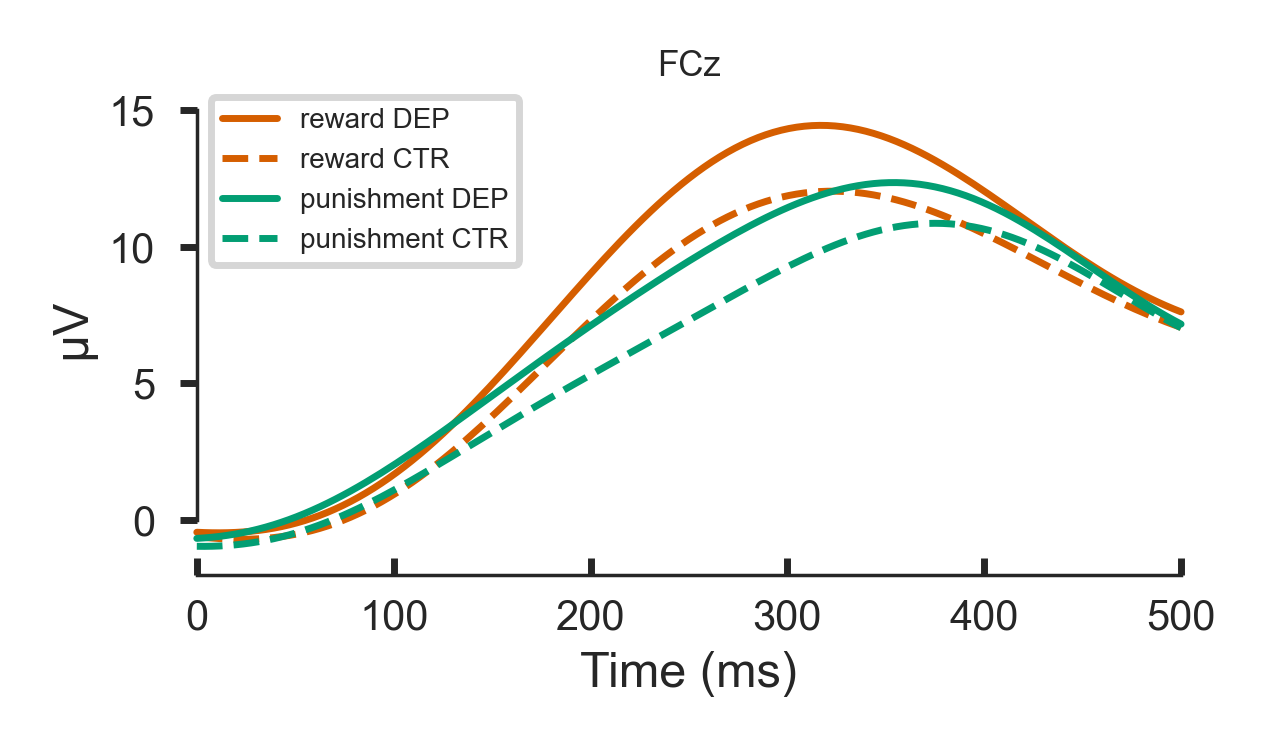

In [71]:
# plot parameters
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.titlesize'] = 5
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)
plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2

picks = ["FCz"]
ax = fig.add_axes([0, 0, 0.78, 0.78])

fig = plt.figure(figsize=(5*cm, 2.5*cm))
ax = fig.add_axes([0,0,1,1], zorder=-1)

a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
    show_sensors=False,
    show=False,
    styles={
        "reward DEP": {"linestyle": '-'},
        "reward CTR": {"linestyle": '--'},
        "punishment DEP": {"linestyle": '-'},
        "punishment CTR": {"linestyle": '--'},

    },
    colors = [sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[2]]

    
    
)

ax.tick_params(axis='x', direction='in', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)


plt.show()

fig.savefig(f'data/figure_1/delta_dep_smaller', bbox_inches='tight', pad_inches=0.01)

#### Depression: theta

In [ ]:
depression_epochs = mne.concatenate_epochs(dep['theta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_dep['theta'].to_list())

In [73]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.0, tmax=0.5) for name in ('f_good', 'f_bad')]

evokeds = {
    'reward DEP': evokeds_dep[0],
    'reward CTR': evokeds_dep_ctr[0],
    'punishment DEP' : evokeds_dep[1],
    'punishment CTR' : evokeds_dep_ctr[1],
}

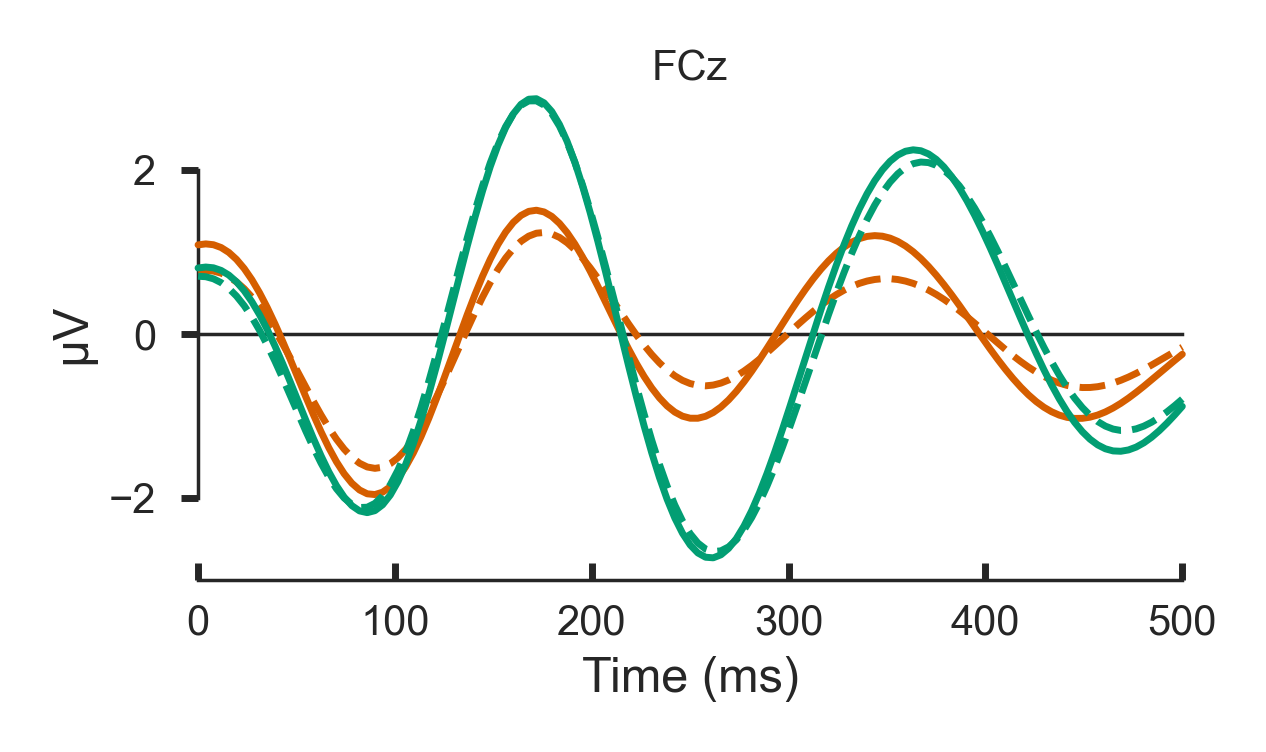

In [78]:
# plot parameters
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 5
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2

# create canvas
fig = plt.figure(figsize=(5*cm, 2.5*cm))
ax = fig.add_axes([0,0,1,1], zorder=-1)

picks = ["FCz"]

a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
    show_sensors=False,
    show=False,
    legend=False,
    styles={
        "reward DEP": {"linestyle": '-'},
        "reward CTR": {"linestyle": '--'},
        "punishment DEP": {"linestyle": '-'},
        "punishment CTR": {"linestyle": '--'},

    },
    colors = [sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[2]]

    
    
)
ax.tick_params(axis='x', direction='in', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()

fig.savefig(f'data/figure_1/theta_dep_smaller', bbox_inches='tight', pad_inches=0.01)

#### Anxiety: delta

In [ ]:
depression_epochs = mne.concatenate_epochs(anx['delta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['delta'].to_list())

In [20]:
evokeds_dep = [depression_epochs[name].average().copy().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().copy().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]

evokeds = {
    'reward ANX': evokeds_dep[0],
    'reward CTR': evokeds_dep_ctr[0],
    'punishment ANX' : evokeds_dep[1],
    'punishment CTR' : evokeds_dep_ctr[1],
}

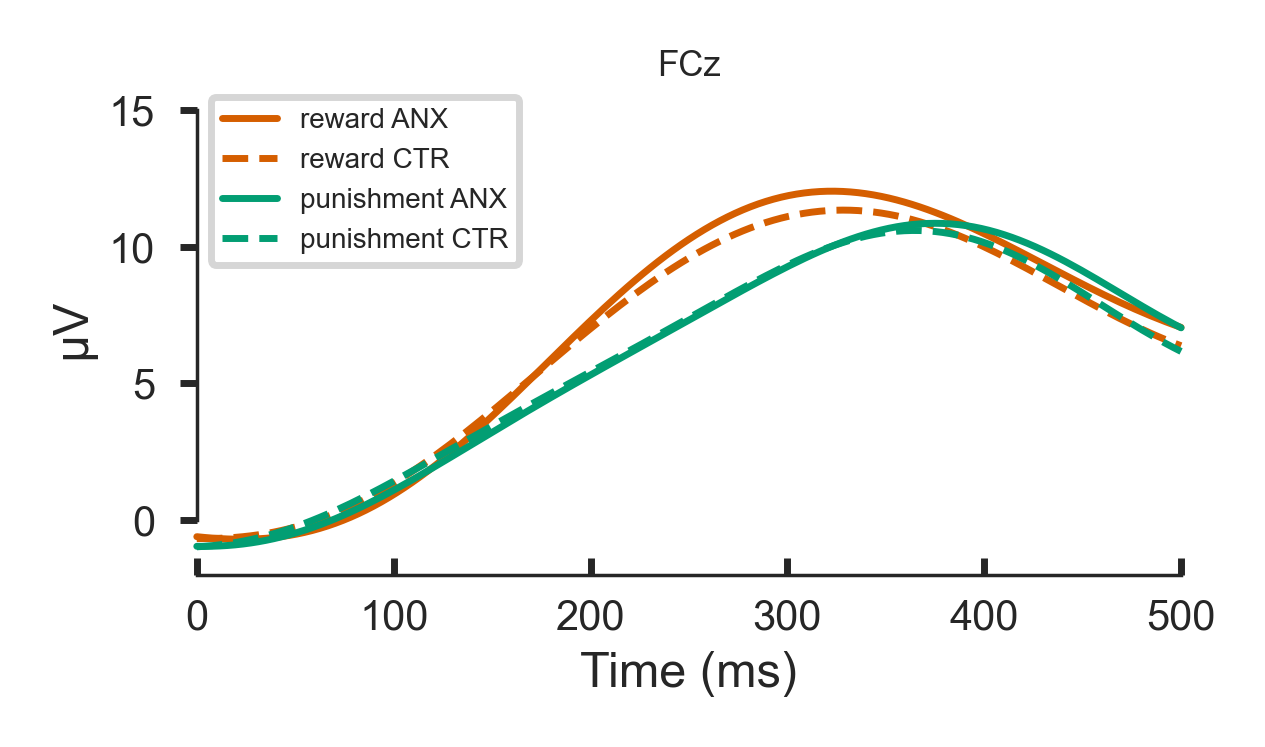

In [21]:
# plot parameters
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 5
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=4)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2

fig = plt.figure(figsize=(5*cm, 2.5*cm))
ax = fig.add_axes([0,0,1,1], zorder=-1)

picks = ["FCz"]

a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-2, 16]),
    axes=ax,
    time_unit='ms',
    show_sensors=False,
    show=False,
    styles={
        "reward ANX": {"linestyle": '-'},
        "reward CTR": {"linestyle": '--'},
        "punishment ANX": {"linestyle": '-'},
        "punishment CTR": {"linestyle": '--'},

    },
    colors = [sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[2]]

    
    
)

ax.tick_params(axis='x', direction='in', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()

fig.savefig(f'data/figure_1/delta_anx_smaller', bbox_inches='tight', pad_inches=0.01)

#### Anxiety: theta

In [ ]:
depression_epochs = mne.concatenate_epochs(anx['theta'].to_list())
depression_ctr_epochs = mne.concatenate_epochs(ctrl_anx['theta'].to_list())

In [87]:
evokeds_dep = [depression_epochs[name].average().crop(tmin=0.0, tmax=0.5) for name in ('f_good', 'f_bad')]
evokeds_dep_ctr = [depression_ctr_epochs[name].average().crop(tmin=-0.0, tmax=0.5) for name in ('f_good', 'f_bad')]

evokeds = {
    'reward ANX': evokeds_dep[0],
    'reward CTR': evokeds_dep_ctr[0],
    'punishment ANX' : evokeds_dep[1],
    'punishment CTR' : evokeds_dep_ctr[1],
}

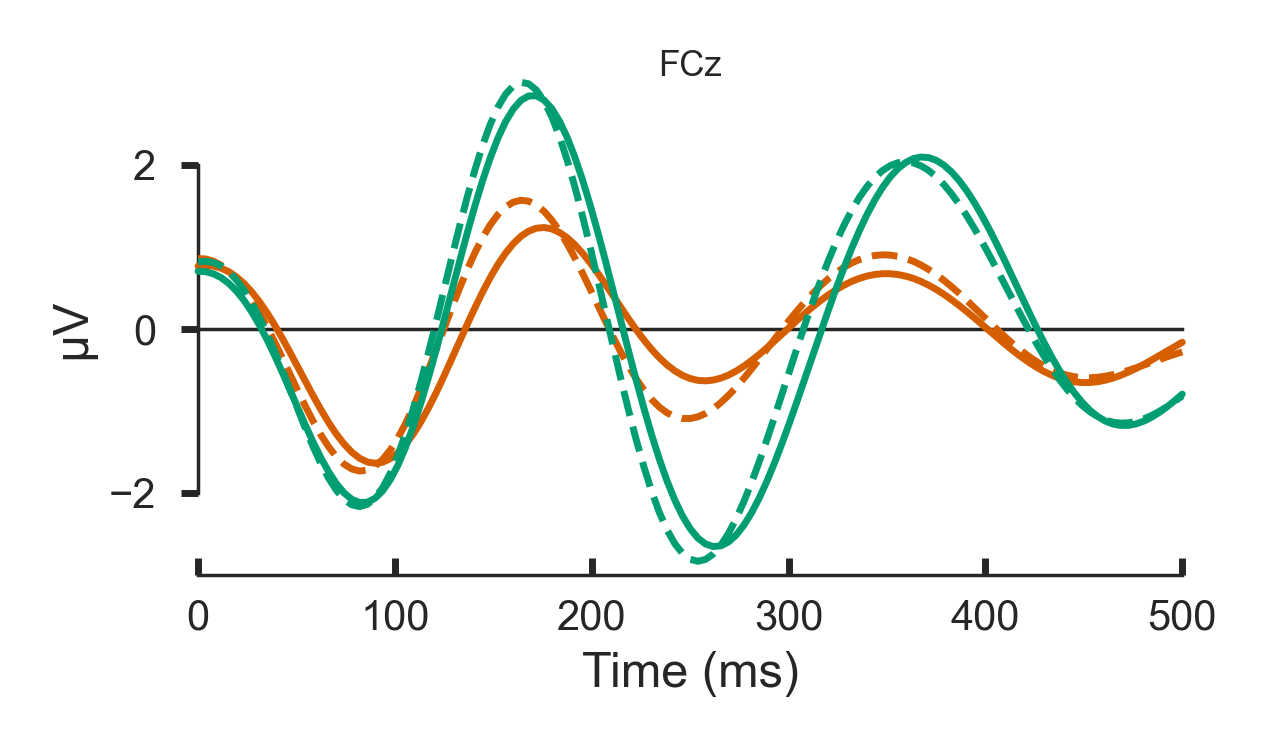

In [90]:
# plot parameters
cm = 1/2.54
dpi = 500

plt.rc('font', size=4)
sns.set_style("ticks")
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams["axes.edgecolor"] = ".15"
plt.rcParams["axes.linewidth"]  = 0.5
plt.rcParams['lines.linewidth'] = 1

plt.rcParams['axes.spines.bottom']= True
plt.rcParams['axes.spines.left']= True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True

plt.rcParams['axes.titlesize'] = 5
plt.rcParams['figure.frameon'] = True
plt.rc('legend',fontsize=3)

plt.rcParams['axes.titlepad'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['axes.titlepad'] = 0.2

fig = plt.figure(figsize=(5*cm, 2.5*cm))
ax = fig.add_axes([0,0,1,1], zorder=-1)

picks = ["FCz"]

a = mne.viz.plot_compare_evokeds(
    evokeds, 
    picks=picks, 
    ci=0.95, 
    ylim=dict(eeg=[-3, 3]),
    axes=ax,
    time_unit='ms',
    show_sensors=False,
    show=False,
    legend=False,
    styles={
        "reward ANX": {"linestyle": '-'},
        "reward CTR": {"linestyle": '--'},
        "punishment ANX": {"linestyle": '-'},
        "punishment CTR": {"linestyle": '--'},

    },
    colors = [sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[3],sns.color_palette("colorblind")[2],sns.color_palette("colorblind")[2]]

    
    
)

ax.tick_params(axis='x', direction='in', length=2.5, width=1)
ax.tick_params(axis='y', direction='out', length=2.5, width=1)

plt.show()


fig.savefig(f'data/figure_1/theta_anx_smaller', bbox_inches='tight', pad_inches=0.01)

## CSP components patterns visualization

In [14]:
tmin = 0.20
tmax = 0.30
picks=['']

Create datasets with eeg signal

In [16]:
rewp_depression_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    dep_data = [mne.filter.resample(epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in dep[freq].to_numpy()]
    ctrl_data = [mne.filter.resample(epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,), down=1.0) for epoch in ctrl_dep[freq].to_numpy()]

    X = np.array(dep_data + ctrl_data)
    rewp_depression_datasets.append(X)

In [17]:
frn_depression_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    dep_data = [epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in dep[freq].to_numpy()]
    ctrl_data = [epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_dep[freq].to_numpy()]

    X = np.array(dep_data + ctrl_data)
    frn_depression_datasets.append(X)

In [18]:
rewp_anxiety_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    anx_data = [epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx[freq].to_numpy()]
    ctrl_data = [epoch['f_good'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx[freq].to_numpy()]

    X = np.array(anx_data + ctrl_data)
    rewp_anxiety_datasets.append(X)

In [19]:
frn_anxiety_datasets = []
frequencies = ['delta', 'theta']

for freq in frequencies:
    anx_data = [epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in anx[freq].to_numpy()]
    ctrl_data = [epoch['f_bad'].average().get_data(tmin=tmin, tmax=tmax,) for epoch in ctrl_anx[freq].to_numpy()]

    X = np.array(anx_data + ctrl_data)
    frn_anxiety_datasets.append(X)

Read the estimated models

In [20]:
results_dep_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/depression_rewp_freq_results_t20-t30_01_06_sonata.pkl")
results_dep_frn_df = pd.read_pickle("data/sonata_data/results/GNG/depression_frn_results_freq_t20-t30_01_06_sonata.pkl")
results_anx_rewp_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_rewp_freq_results_t20-t30_01_06_sonata.pkl")
results_anx_frn_df = pd.read_pickle("data/sonata_data/results/GNG/anxiety_frn_freq_results_t20-t30_01_06_sonata.pkl")

Extract CSP components from the best models

In [21]:
dep_rewp_delta_model_csp = results_dep_rewp_df.iloc[0].best_model[0]
dep_rewp_theta_model_csp = results_dep_rewp_df.iloc[1].best_model[0]
dep_frn_delta_model_csp = results_dep_frn_df.iloc[0].best_model[0]
dep_frn_theta_model_csp = results_dep_frn_df.iloc[1].best_model[0]

anx_rewp_delta_model_csp = results_anx_rewp_df.iloc[0].best_model[0]
anx_rewp_theta_model_csp = results_anx_rewp_df.iloc[1].best_model[0]
anx_frn_delta_model_csp = results_anx_frn_df.iloc[0].best_model[0]
anx_frn_theta_model_csp = results_anx_frn_df.iloc[1].best_model[0]

In [110]:
# plot CSP patterns estimated on full data for visualization
def plot_csp(info, csp, data, epochs, figname='out'):
    cm = 1/2.54
    dpi = 500

    plt.rc('font', size=5)
    sns.set_style("ticks")
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams['ytick.labelsize'] = 6
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['axes.labelsize'] = 7
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['axes.spines.bottom']= True
    plt.rcParams['axes.spines.left']= True
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True
    plt.rcParams['axes.titlesize'] = 5
    plt.rcParams['figure.frameon'] = True
    plt.rc('legend',fontsize=3)
    plt.rcParams['axes.titlepad'] = 0.2
    plt.rcParams['axes.labelpad'] = 2
    plt.rcParams['axes.titlepad'] = 0.2

    fig = plt.figure(figsize=(5*cm, 2.5*cm))
    
    chs = np.array(info.ch_names)
    channels_to_remove = np.array(['EXG1','EXG2','EXG3','EXG4', 'P9', 'Iz', 'P10'])
    indexes = (chs[:, None] == channels_to_remove).argmax(axis=0)

    info_new = epochs.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').drop_channels(channels_to_remove).info

    patterns = csp.patterns_
    patterns_new = np.delete(patterns, indexes, 0)
    patterns_new = np.delete(patterns_new, indexes, 1)

    new_csp = copy.deepcopy(csp)
    new_csp.patterns_ = patterns_new

    a = new_csp.plot_patterns(
        info_new, 
        ch_type="eeg",
        units="Patterns (AU)", 
        show=False,
        colorbar=False,
        res=dpi, 
        size=1.5*cm
    )    
    plt.savefig(f'data/figure_1_new/{figname}', bbox_inches='tight', pad_inches=0.01)
    plt.show()

In [153]:
def plot_differences_betten_groups_CSP_space(csp, X_1, X_2, labels, info, epochs, vlim=(None,None), figname=None):
    cm = 1/2.54
    dpi = 500

    plt.rc('font', size=5)
    sns.set_style("ticks")
    plt.rcParams['figure.dpi'] = dpi
    plt.rcParams['ytick.labelsize'] = 6
    plt.rcParams['xtick.labelsize'] = 6
    plt.rcParams['axes.labelsize'] = 7
    plt.rcParams["axes.edgecolor"] = ".15"
    plt.rcParams["axes.linewidth"]  = 0.5
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['axes.spines.bottom']= True
    plt.rcParams['axes.spines.left']= True
    plt.rcParams['axes.spines.right'] = True
    plt.rcParams['axes.spines.top'] = True
    plt.rcParams['axes.titlesize'] = 5
    plt.rcParams['figure.frameon'] = True
    plt.rc('legend',fontsize=3)
    plt.rcParams['axes.titlepad'] = 0.2
    plt.rcParams['axes.labelpad'] = 2
    plt.rcParams['axes.titlepad'] = 0.2

    n_components = csp.n_components
    
    ###### EXTRACT FILTERS ############
    chs = np.array(info.ch_names)
    channels_to_remove = np.array(['EXG1','EXG2','EXG3','EXG4', 'P9', 'Iz', 'P10'])
    indexes = (chs[:, None] == channels_to_remove).argmax(axis=0)

    info_new = epochs.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').drop_channels(channels_to_remove).info

    filters_ = csp.filters_
    filters_new = np.delete(filters_, indexes, 0)
    filters_new = np.delete(filters_, indexes, 1)

    new_csp = copy.deepcopy(csp)
    new_csp.filters_ = filters_new
    
    X_1_new = np.delete(np.array(X_1), indexes, 1)
    X_2_new = np.delete(np.array(X_2), indexes, 1)
    
    ###### EXTRACT CSP DIFFERENCE BETWEEN GROUPS ############3
    filters = new_csp.filters_[:n_components]
        
    diff_ = np.mean(X_1_new, axis=0) - np.mean(X_2_new, axis=0) # diff between averages of groups
    diff_ = np.mean(diff_, axis=-1) # average in time-window
    diff_filtered_ = diff_ * filters
    
    X_1_filtered = np.mean(np.mean(X_1_new, axis=0), axis=-1) * filters
    X_2_filtered = np.mean(np.mean(X_2_new, axis=0), axis=-1) * filters

    # plot the signal difference
    fig, contours = mne.viz.plot_topomap(
            diff_, 
            info_new, 
            show=False, 
            res=dpi, 
            contours=3, 
            size=1.5*cm,
    )
    plt.setp(contours.collections , linewidth=0.2)
    plt.setp(fig.axes.lines , linewidth=0.5)
    
    gridspec_kw = {
        'wspace':0.02,
        'hspace':0.07,
    }

    # plot the CSP difference
    fig, axes = plt.subplots(3, n_components,figsize=(n_components*2*cm, 5*cm), gridspec_kw=gridspec_kw)
    for index in range(0,n_components):
        ax_ = axes[2][index] if n_components > 1 else axes[0]
        
        print(np.mean(diff_filtered_[index]))
        
        fig_csp, contours = mne.viz.plot_topomap(
            diff_filtered_[index], 
            info_new, 
            show=False, 
            res=dpi, 
            contours=3, 
            size=3*cm,
            vlim=vlim,
            axes= ax_,
            sensors=False,
        )
        
        plt.setp(contours.collections , linewidth=0.2)
        plt.setp(ax_.lines , linewidth=0.5)
        
        ax_ = axes[0][index] if n_components > 1 else axes[1]

        fig_csp_2, contours = mne.viz.plot_topomap(
            X_1_filtered[index], 
            info_new, 
            show=False, 
            res=dpi, 
            contours=3, 
            size=1.5*cm,
            vlim=vlim,
            axes= ax_,
            sensors=False,
        )
        plt.setp(contours.collections , linewidth=0.2)
        plt.setp(ax_.lines , linewidth=0.5)
        
        ax_ = axes[1][index] if n_components > 1 else axes[2]

        fig_csp_3, contours = mne.viz.plot_topomap(
            X_2_filtered[index], 
            info_new, 
            show=False, 
            res=dpi, 
            contours=3, 
            size=1.5*cm,
            vlim=vlim,
            axes= ax_,
            sensors=False,
        )
        plt.setp(contours.collections , linewidth=0.2)
        plt.setp(ax_.lines , linewidth=0.5)
    
    plt.savefig(f'data/figure_1_new/{figname}', bbox_inches='tight', pad_inches=0.01)
    plt.show()

#### Depression RewP delta

CSP patterns

In [111]:
data = rewp_depression_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_rewp_delta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

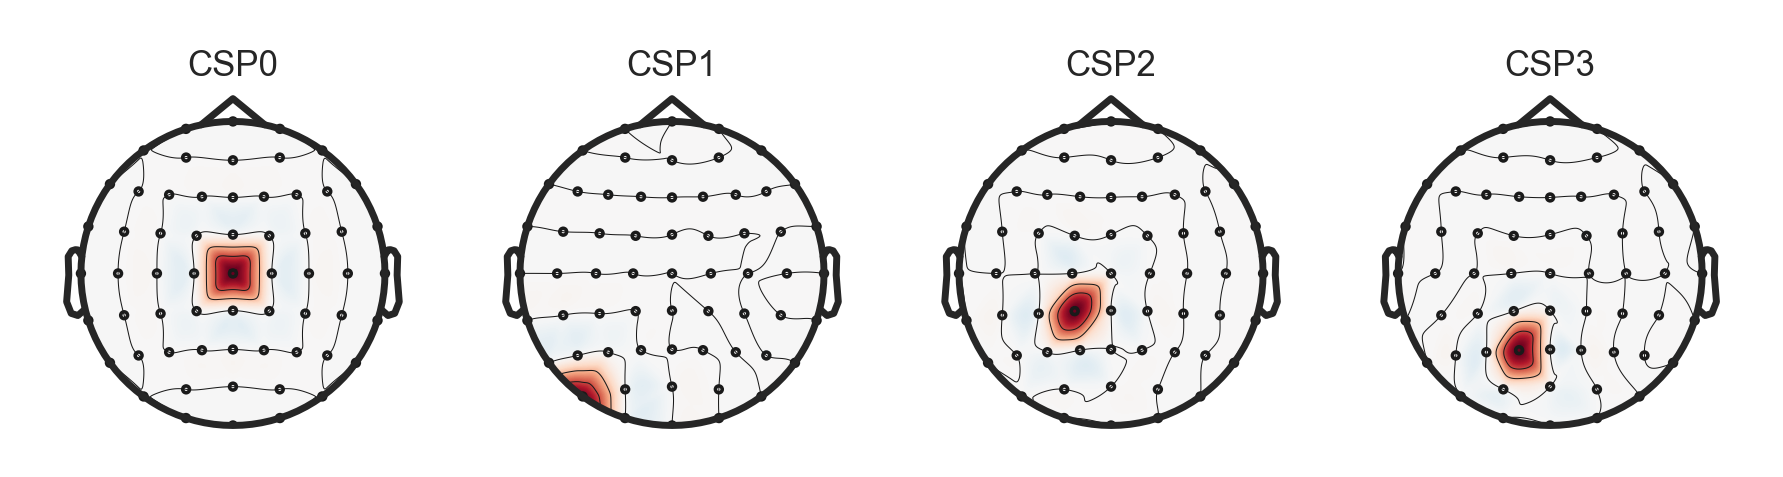

In [112]:
plot_csp(info, csp, data, epochs = dep, figname='dep_rewp_delta_csp')

CSP patterns diff between groups

In [154]:
data = rewp_depression_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info

dep_data_ = data[:len(dep)]
dep_ctrl_data_ = data[len(dep):]

0.003125314519322548
0.000316641783406799
0.002707732457414352
0.0021259898435125905


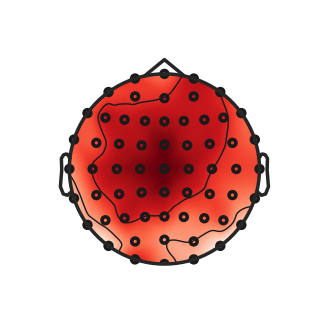

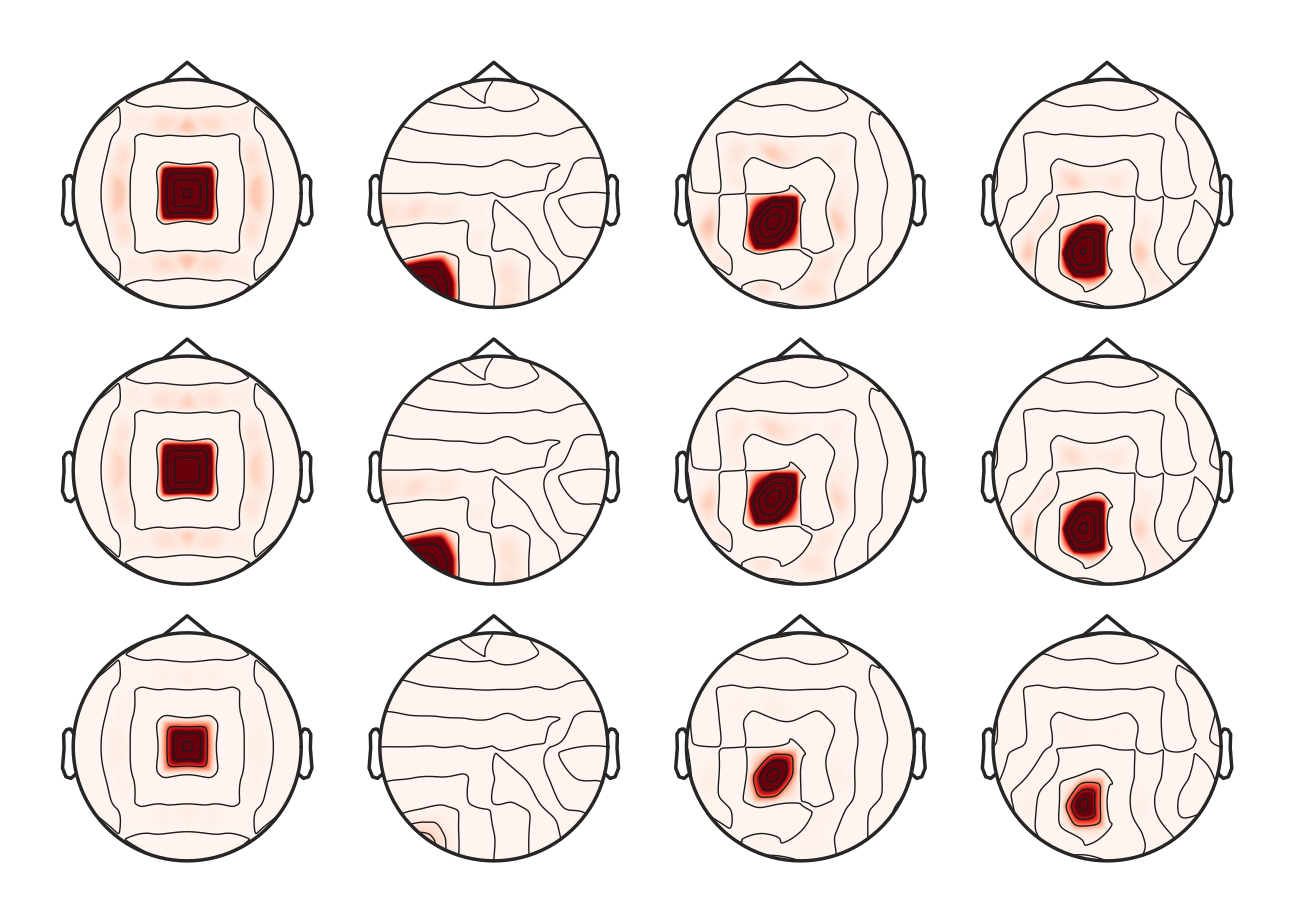

In [155]:
plot_differences_betten_groups_CSP_space(
    dep_rewp_delta_model_csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    epochs=dep, 
    vlim=(0, 0.1),
    figname = 'dep_delta_diff'
)

#### Depression RewP theta

CSP patterns

In [113]:
data = rewp_depression_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_rewp_theta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

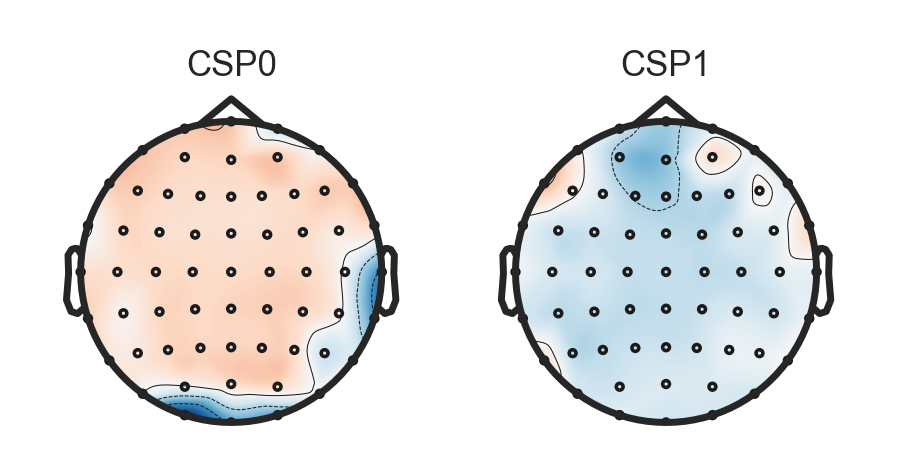

In [114]:
plot_csp(info, csp, data, epochs=dep, figname = 'dep_rewp_theta_csp')

CSP patterns diff between groups

In [157]:
data = rewp_depression_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_rewp_theta_model_csp

dep_data_ = data[:len(dep)]
dep_ctrl_data_ = data[len(dep):]

-0.0010270756414516823
-0.0011659974094359018


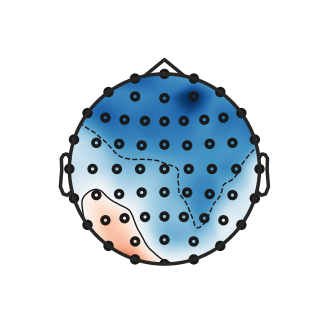

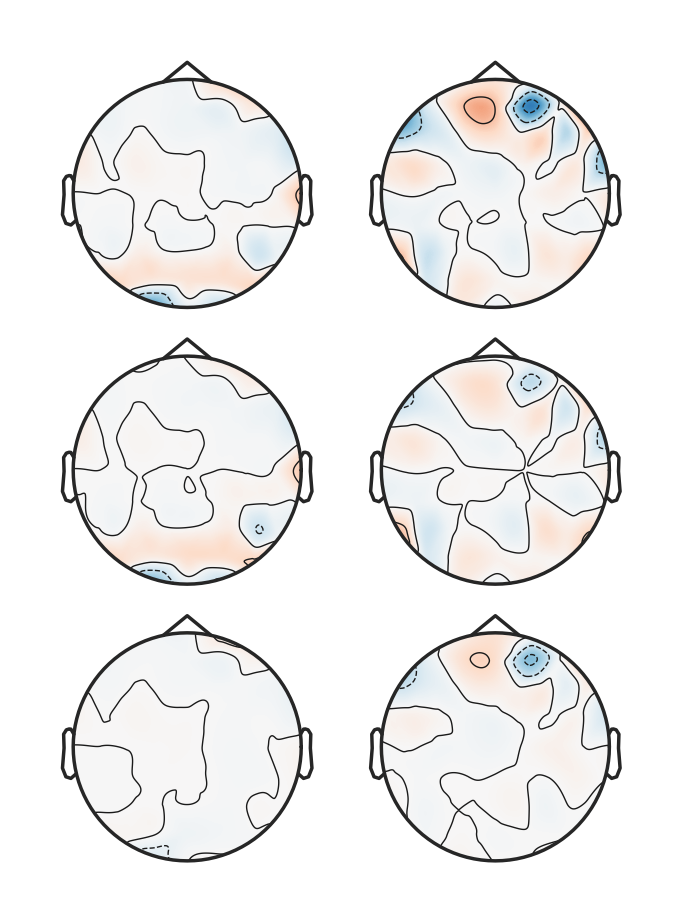

In [158]:
plot_differences_betten_groups_CSP_space(
    csp, dep_data_,
    dep_ctrl_data_, 
    labels,
    info, 
    epochs=dep, 
    vlim=(-0.2,0.2),
    figname='dep_theta_diff'
)

#### Depression FRN delta

CSP patterns

In [115]:
data = frn_depression_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_frn_delta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

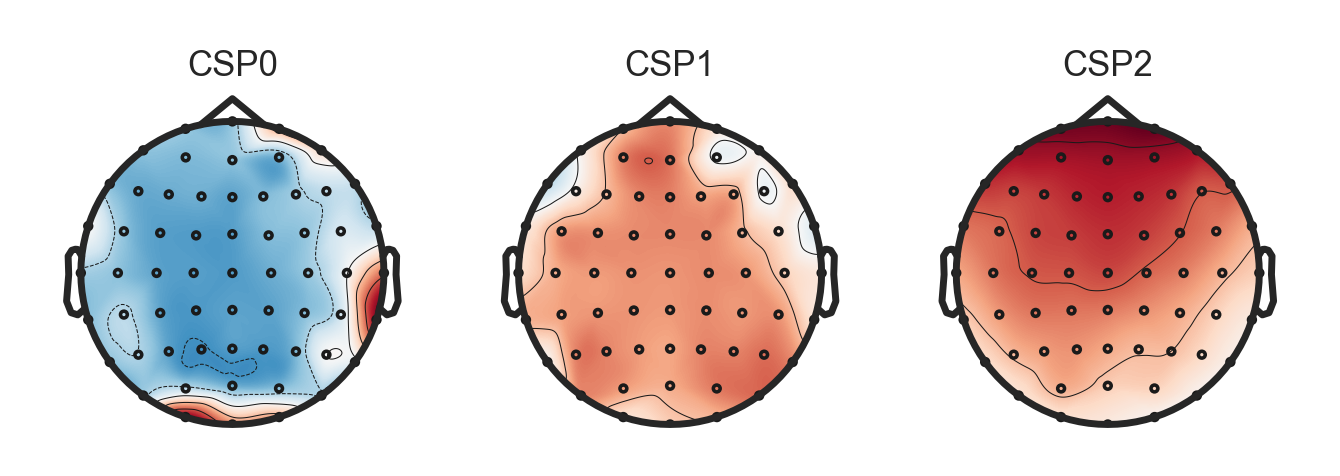

In [116]:
plot_csp(info, csp, data, epochs=dep, figname = 'dep_frn_delta_csp')

CSP patterns diff between groups

In [160]:
data = frn_depression_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_frn_delta_model_csp

dep_data_ = data[:len(dep)]
dep_ctrl_data_ = data[len(dep):]

0.0015449390897964762
-0.0023386871802399912
0.003547056574247542


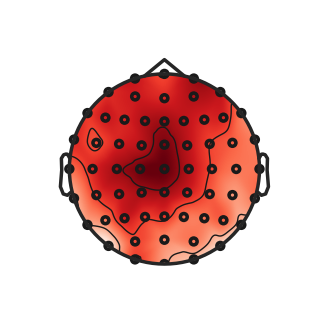

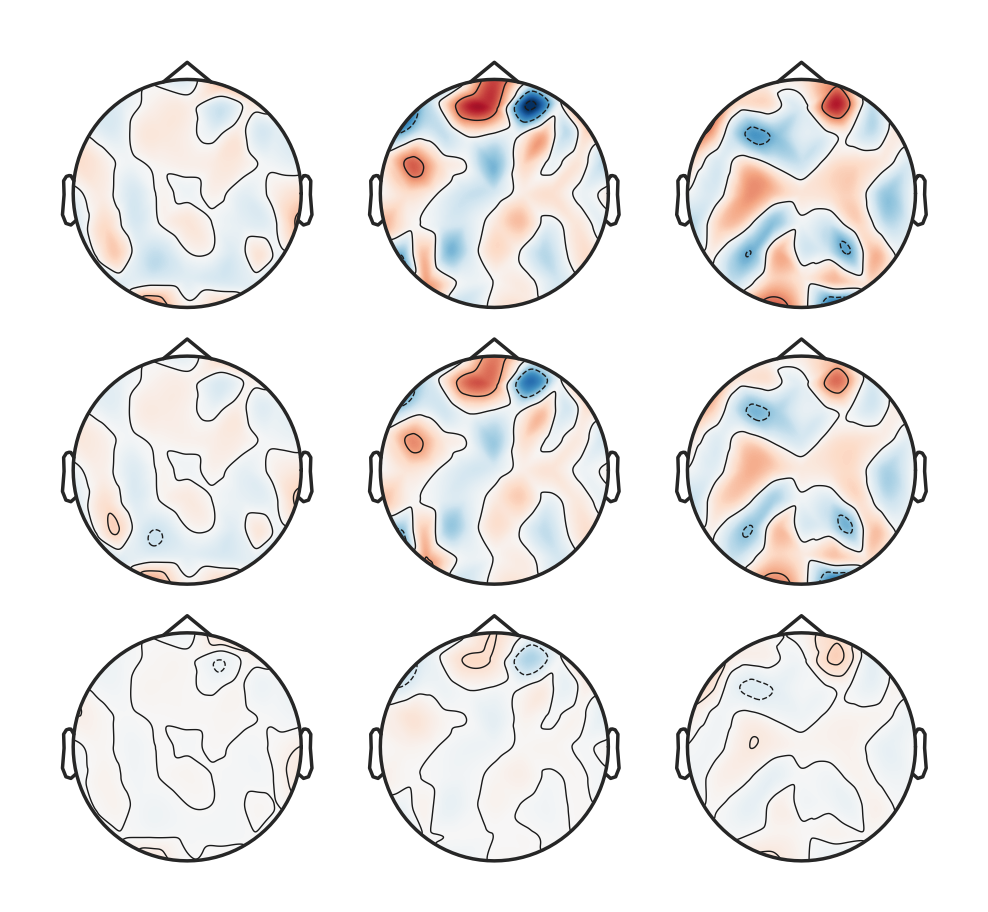

In [161]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    epochs=dep, 
    vlim=(-0.5,0.5),
    figname='dep_delta_frn_diff'
)

#### Depression FRN theta

CSP patterns

In [117]:
data = frn_depression_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_frn_theta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

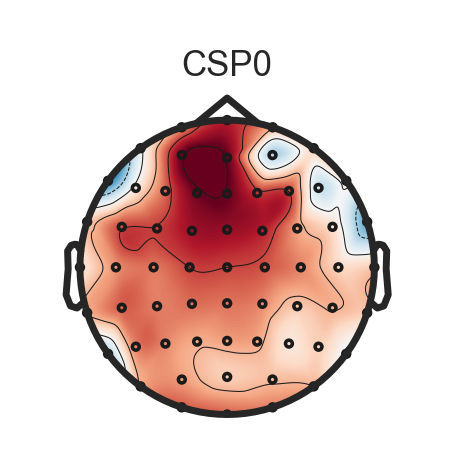

In [118]:
plot_csp(info, csp, data, epochs=dep,figname = 'dep_frn_theta_csp')

CSP patterns diff between groups

In [162]:
data = frn_depression_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = dep.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = dep_frn_theta_model_csp

dep_data_ = data[:len(dep)]
dep_ctrl_data_ = data[len(dep):]

0.0018955383246541805


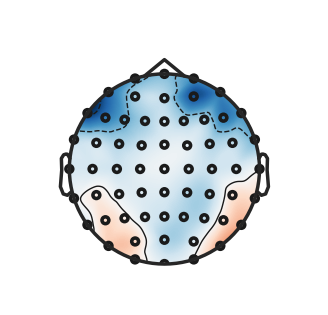

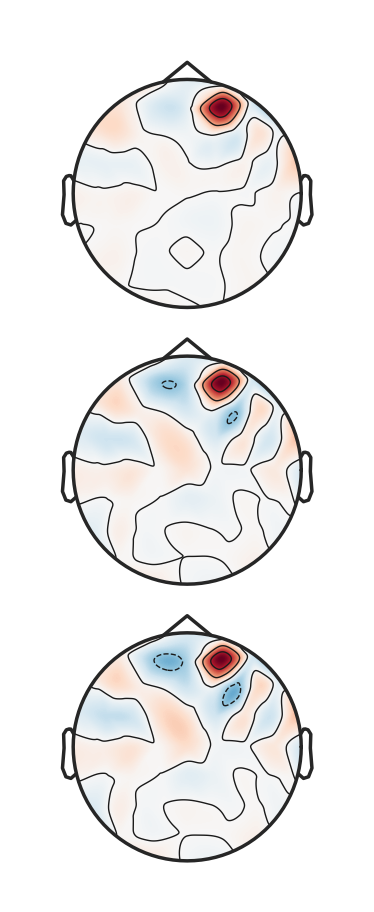

In [163]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels,
    info, 
    epochs=dep, 
    figname = 
    'dep_theta_frn_diff'
)

#### Anxiety RewP delta

CSP patterns

In [119]:
data = rewp_anxiety_datasets[0]
labels = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_rewp_delta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

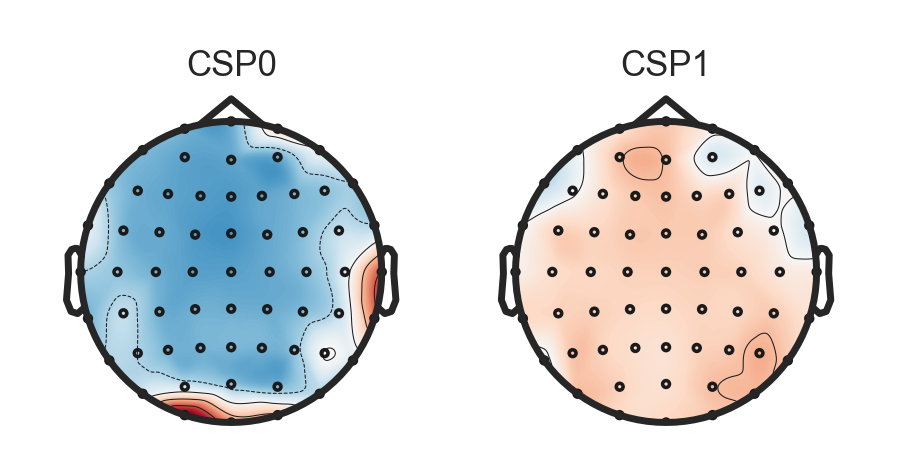

In [120]:
plot_csp(info, csp, data, epochs=anx, figname='anx_rewp_delta_csp')

CSP patterns diff between groups

In [166]:
data = rewp_anxiety_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_rewp_delta_model_csp

dep_data_ = data[:len(anx)]
dep_ctrl_data_ = data[len(anx):]

-0.0017106538611797036
0.001908124777811992


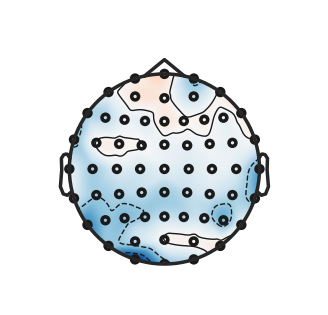

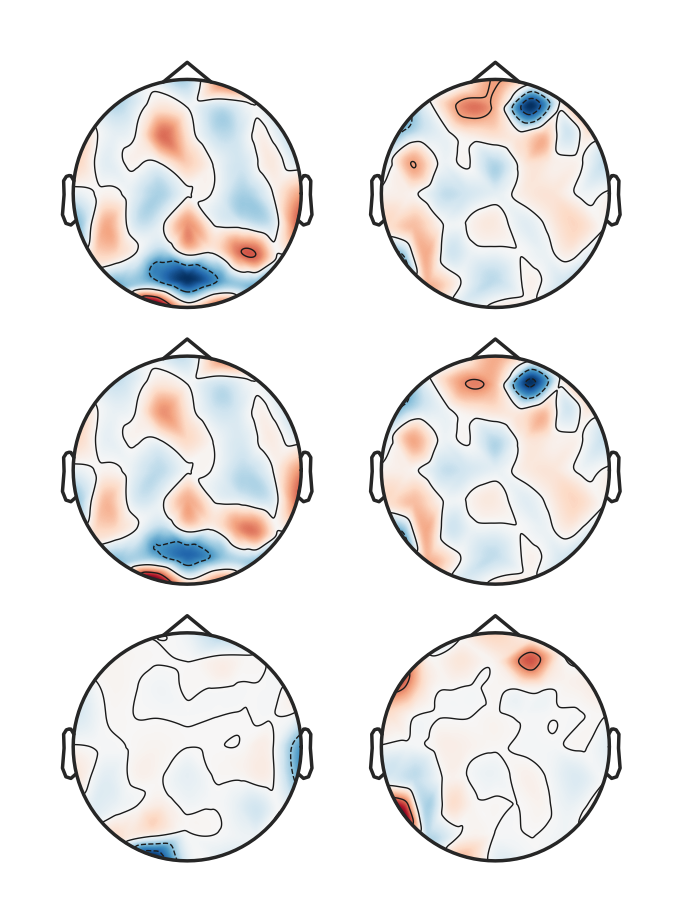

In [167]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    epochs=anx,
    figname='anx_delta_rewp_diff'
)

#### Anxiety RewP theta

CSP patterns

In [121]:
data = rewp_anxiety_datasets[1]
labels = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_rewp_theta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

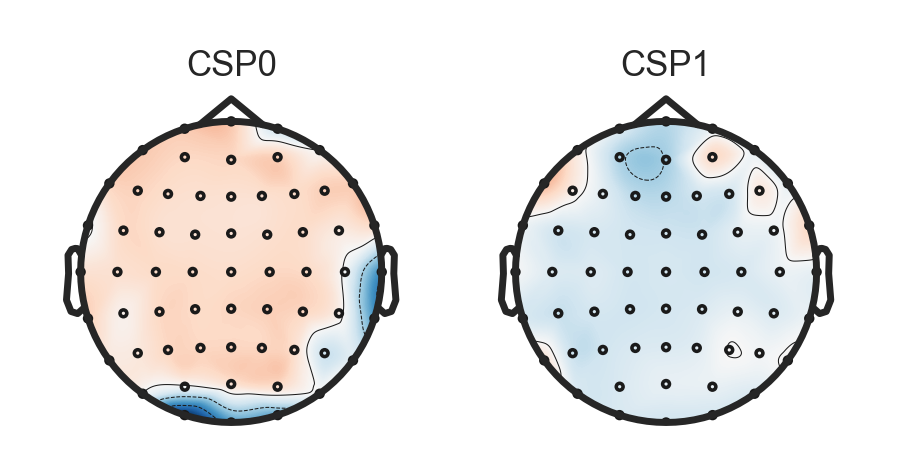

In [122]:
plot_csp(info, csp, data, epochs=anx, figname = 'anx_rewp_theta_csp')

CSP patterns diff between groups

In [168]:
data = rewp_anxiety_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_rewp_theta_model_csp

dep_data_ = data[:len(anx)]
dep_ctrl_data_ = data[len(anx):]

0.0014056237859342035
0.0012647689751694301


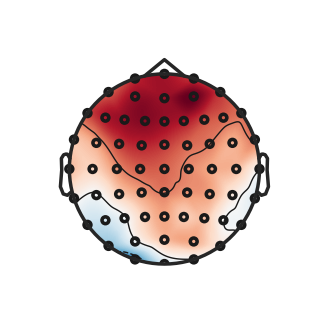

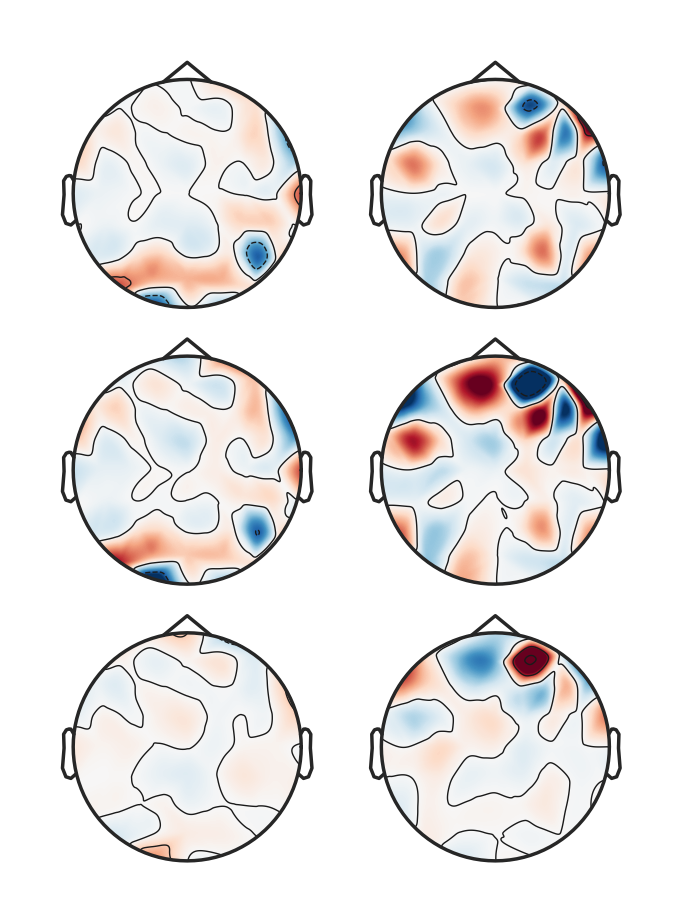

In [169]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    vlim=(-0.1,0.1),
    epochs=anx,
    figname='anx_theta_rewp_diff'
)

#### Anxiety FRN delta

CSP patterns

In [123]:
data = frn_anxiety_datasets[0]
labels = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_frn_delta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

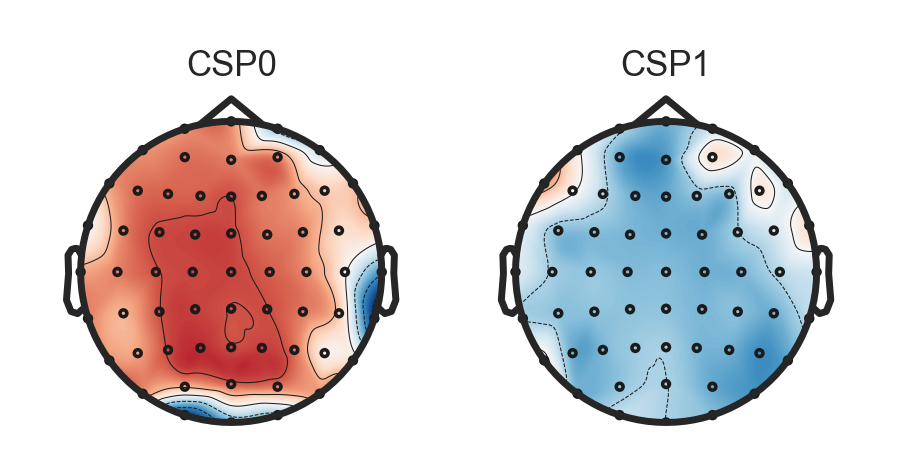

In [124]:
plot_csp(info, csp, data, epochs=anx, figname = 'anx_frn_delta_csp')

CSP patterns diff between groups

In [174]:
data = frn_anxiety_datasets[0]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_frn_delta_model_csp

dep_data_ = data[:len(anx)]
dep_ctrl_data_ = data[len(anx):]

0.001927683407399792
-0.0015666900395386425


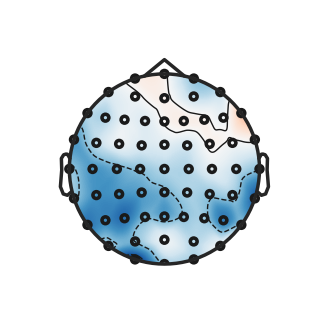

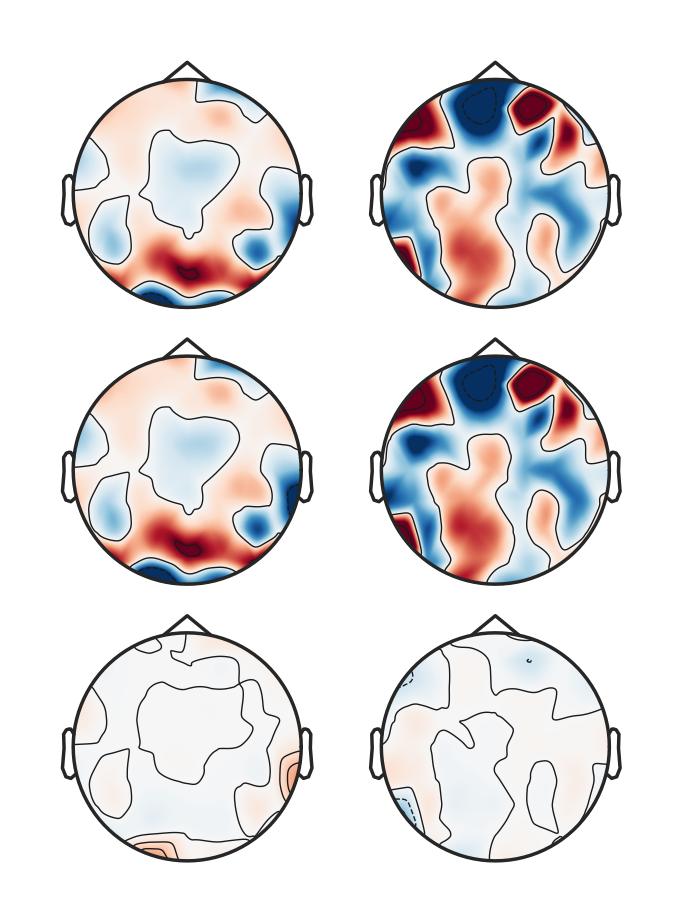

In [175]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    vlim=(-0.1, 0.1),
    epochs=anx,
    figname='anx_delta_frn_diff'
)

#### Anxiety FRN theta

CSP patterns

In [125]:
data = frn_anxiety_datasets[1]
labels = np.array(len(anx) * [1] +  len(ctrl_anx) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_frn_theta_model_csp

<Figure size 984.252x492.126 with 0 Axes>

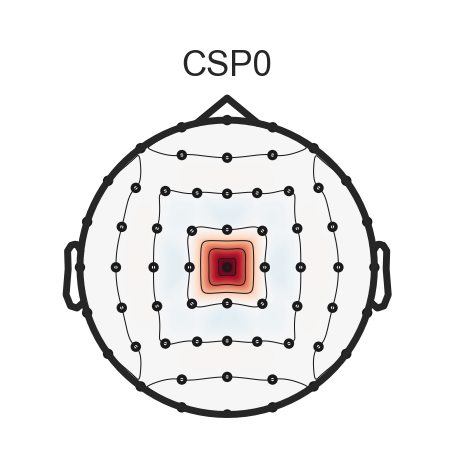

In [126]:
plot_csp(info, csp, data, epochs=anx, figname = 'anx_frn_theta_csp')

CSP patterns diff between groups

In [188]:
data = frn_anxiety_datasets[1]
labels = np.array(len(dep) * [1] +  len(ctrl_dep) * [0])
info = anx.iloc[0].epochs.copy().crop(tmin,tmax).pick('eeg').info
csp = anx_frn_theta_model_csp

dep_data_ = data[:len(anx)]
dep_ctrl_data_ = data[len(anx):]

0.00038927097955724764


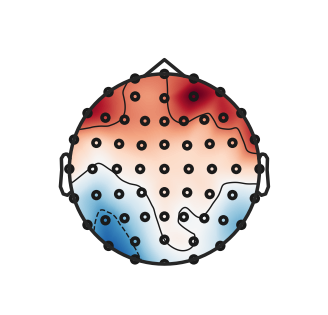

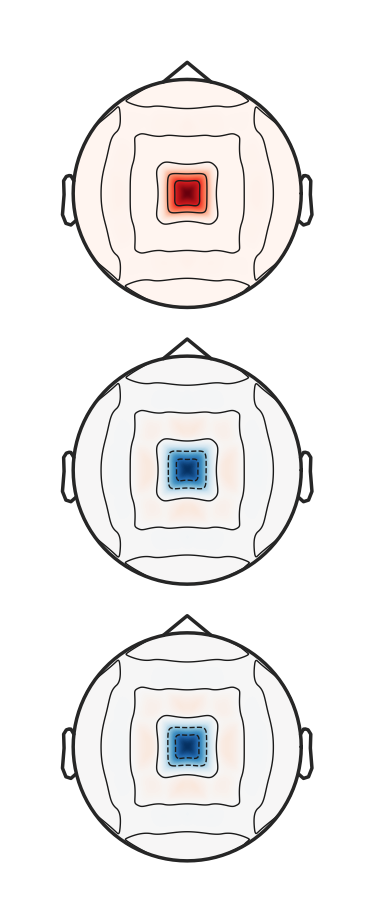

In [206]:
plot_differences_betten_groups_CSP_space(
    csp, 
    dep_data_, 
    dep_ctrl_data_, 
    labels, 
    info, 
    # vlim=(-0.1,0.1),
    epochs=anx,
    figname='anx_theta_frn_diff'
)